Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# import all necessary packages
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D , Activation, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Sequential
#from google.colab import drive

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
## If you are using the data by mounting the google drive, use the following :

## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
# remove the augumented output folder on training dataset if exist
try:
    import shutil
    shutil.rmtree('Skin cancer ISIC The International Skin Imaging Collaboration')
except:
    print("must be permission denied or import shutil package not found or directory not found")

In [4]:
#Now lets freshly unzip the Dataset under Local colab folder
!unzip CNN_assignment.zip

Archive:  CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The I

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
# list all existing output folder
list(data_dir_train.glob('**/output'))

[]

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [8]:
# set seed to 123 on numy and tensor
np.random.seed(123)
tf.random.set_seed(123)

### Create a dataset

Define some parameters for the loader:

In [9]:
# Defining parameters for model
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 20% validation split
  subset="training", # take train dataset
  seed=123,   # seed set to 123
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 20% validation split
  subset="validation", # take validation dataset
  seed=123,  # seed set to 123
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# Listing out all the classes of skin cancer and storing them in a list. 
# We are finding the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names

# set the count of number of unique classes
num_classes = len(class_names)

# preview the classes
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [13]:
# Loop through all the batches to find if any batch contains all the 9 classes in it as each batch contains
# only 32 records there might be chances of a batch not having 1 or more classes.
batch = None

# loop on each batch
for i in range(1,len(train_ds)+1):
    
    # extract records from the batch as image and labels
    batch = [(images, labels) for images, labels in train_ds.take(i)]
    
    # print batch number
    print("batch :"+str(i))
    
    # remove previosu batch data
    del batch[: i-1]
    
    # check length to see if all classes are present in the batch
    unique_classes = len(np.unique(batch[0][1]))
    
    # if found exit loop
    if unique_classes == 9:
        print("found all "+str(unique_classes)+" unique classes in the batch "+str(i)+", exiting loop...")
        break
    else:
        print("found "+str(unique_classes)+" unique classes")

batch :1
found 7 unique classes
batch :2
found 7 unique classes
batch :3
found all 9 unique classes in the batch 3, exiting loop...


In [14]:
# batch variable contains records from batch which contains all classes
# extract RGB chnnel matrix of an image from the batch
df_r = batch[0][0][2][:,:,0]
df_g = batch[0][0][2][:,:,1]
df_b = batch[0][0][2][:,:,2]

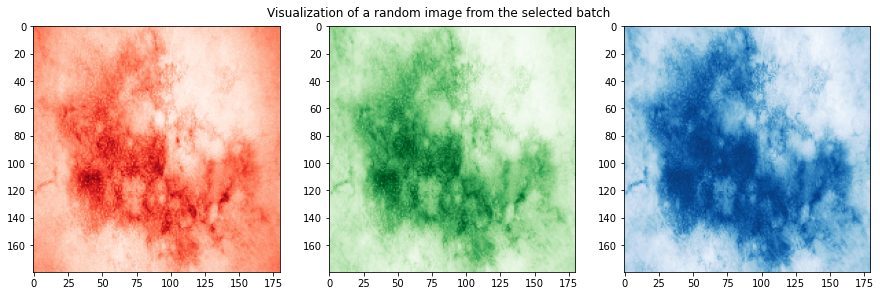

In [15]:
# visualize the image in RGB channel
plt.figure(figsize=(15,10))
i=1
for k,v in dict({'Reds_r':df_r,'Greens_r':df_g,'Blues_r':df_b}).items():
    ax = plt.subplot(1,3,i)
    plt.imshow(v.numpy(),cmap=k)
    i = i + 1
plt.suptitle("Visualization of a random image from the selected batch",x=0.5,y=0.7);

In [16]:
# get the class labels from the batch images
class_labels = pd.Series(batch[0][1]).drop_duplicates().sort_values()

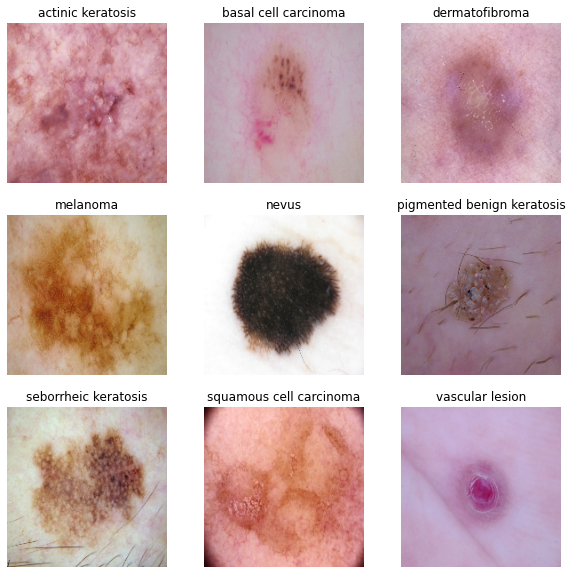

In [17]:
# visualize the image from each class
plt.figure(figsize=(10, 10))

# loop through all the classes and plot the image
for index, value in class_labels.iteritems():
    ax = plt.subplot(3, 3, value + 1)
    plt.imshow(batch[0][0][index].numpy().astype("uint8"))
    plt.title(class_names[value])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
# initializing Autotune and converting the dataset to prefetch type
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3))

# Model 1

In [20]:
model = Sequential()
model.add(norm_layer)

model.add(Conv2D(16, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 43, 128)       18560     
_________________________________________________________________
activation_1 (Activation)    (None, 43, 43, 128)       0

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [21]:
### set Optimiser and loss function as ADAM and SparceCategorialCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# A custom logic to get layer configurationss for a model
def get_model_summary(model):
    
    # create an empty DataFrame
    model_summary_df = pd.DataFrame(columns={'Layer Name':'',
                                             'Filter':1,
                                             'Kernel':'',
                                             'Padding':'',
                                             'Stride':'',
                                             'Pool Size':'',
                                             'Type':'',
                                             'Rate':0.1})
    
    # iterate through all kayers from the built model
    for i,layer in enumerate(model.layers):
        row = {}
        layer_name = layer.name.split('_')[0].title()
        if 'conv' in layer.name:
            row = {'Layer Name':layer_name,'Filter' : layer.filters,'Kernel' : layer.kernel_size,'Stride' :layer.strides,'Padding' : layer.padding}
        elif 'activation' in layer.name:
            row = {'Layer Name':layer_name,'Type' : str(layer.activation)[10:-23]}
        elif 'pooling' in layer.name:
            row = {'Layer Name':layer.name.split('_')[0].title()+layer.name.split('_')[1].title(),'Pool Size':layer.pool_size,'Stride' :layer.strides,'Padding' : layer.padding}
        elif 'dense' in layer.name:
            row = {'Layer Name':layer_name,'Filter' : layer.units}
        elif 'dropout' in layer.name:
            row = {'Layer Name':layer_name,'Rate' : layer.rate}
        else:
            row = {'Layer Name':layer_name}
        model_summary_df = model_summary_df.append(row, ignore_index = True)
    # fill empty values with ''
    model_summary_df = model_summary_df.fillna('')
    
    _,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    # plot the layer type counts
    sns.countplot(y=model_summary_df['Layer Name'].values,ax=ax1);
    ax1.set(title='Layer Count',xticks=[0,1,2,3,4])
    # plot the filter number counts
    sns.countplot(y=model_summary_df.loc[~(model_summary_df['Filter'] ==''),'Filter'].values,ax=ax2);
    ax2.set(title='Filter Count',xticks=[0,1,2])
    
    # return the dataframe
    return model_summary_df

,Layer Name,Filter,Kernel,Padding,Stride,Pool Size,Type,Rate
0,Rescaling,,,,,,,
1,Conv2D,16,"(3, 3)",same,"(1, 1)",,,
2,Activation,,,,,,relu,
3,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
4,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
5,Conv2D,128,"(3, 3)",valid,"(1, 1)",,,
6,Activation,,,,,,relu,
7,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
8,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
9,Flatten,,,,,,,


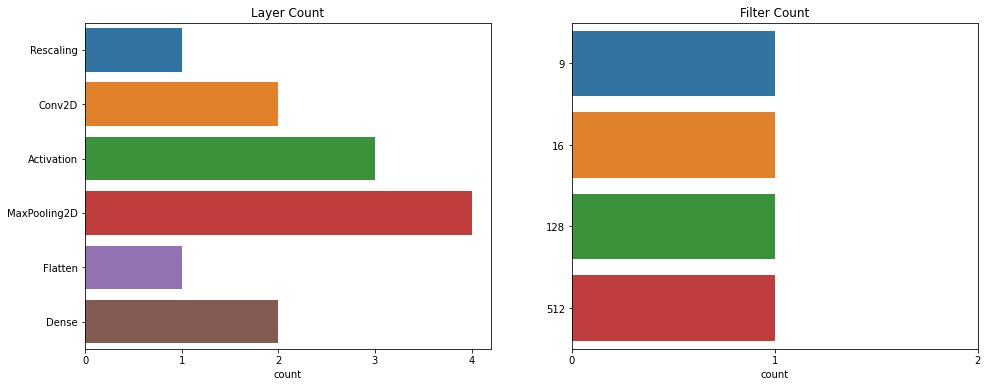

In [23]:
model_1 = get_model_summary(model)

# preview the DF
model_1

### Train the model

In [24]:
# initialize the number of epochs to 20 and fit the buit bold with dataset
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 29ms/step - loss: 2.1084 - accuracy: 0.2286 - val_loss: 1.8111 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 1.7119 - accuracy: 0.3785 - val_loss: 1.5629 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4976 - accuracy: 0.4690 - val_loss: 1.4935 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3920 - accuracy: 0.5264 - val_loss: 1.4576 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3705 - accuracy: 0.5072 - val_loss: 1.4332 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 1.2791 - accuracy: 0.5257 - val_loss: 1.2693 - val_accuracy: 0.5615
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.1382 - accuracy: 0.6056 - val_loss: 1.3906 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing training results

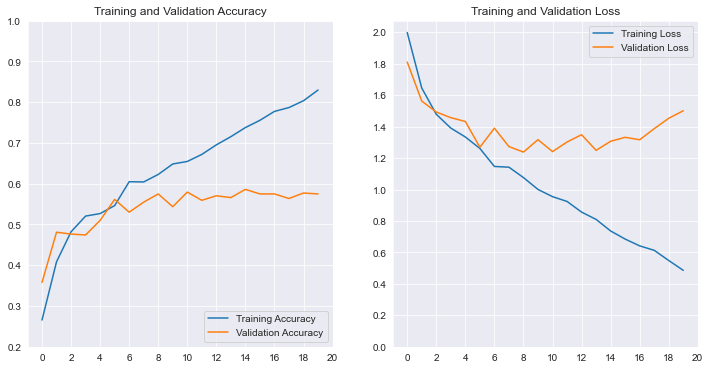

In [25]:
# set style
sns.set_style('darkgrid')

# get the accuracy of trian and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# get the loss of train and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# create subplot and sey figure size
plt.figure(figsize=(12, 6))

# set plot 1
plt.subplot(1, 2, 1)

# plot the accuracy of training and validation split
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# plot legends, title and ticks
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.yticks(np.linspace(0.2,1,9))
plt.xticks(np.linspace(0,20,11))
# set plot 2
plt.subplot(1, 2, 2)

# plot the loss function of training and validation split
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# plot legends, title and ticks
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.yticks(np.linspace(0.0,2,11))
plt.xticks(np.linspace(0,20,11))
plt.show()

## Observation :


*As* you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

We can also notice that the loss of validation decreases initially and increases as we iterate more .ie on every epochs.

Let's look at what went wrong and try to increase the overall performance of the model.

### Overfitting

* In the plots above, the training accuracy is increasing over each epochs to arange of 85-90%, whereas validation accuracy doesn't raise abve 60% in the training process. 

* This difference in accuracy between training and validation accuracy is noticeable sign of overfitting.

This means that the model will not be generalized and might not perform well on a new dataset. The Overfitting can be handled in multiple ways in the training process. 

Lets use *data augmentation* and add *Dropout* and see how it fights overfitting on our model.

# Data Augmentation

Overfitting generally occurs when the training data set is small with a model that could turn out to be complex. Data augmentation generilizies our training data by means of agumentation from your existing examples by using random transformations like rotation and zoom level that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [26]:
# lets add a function which can flip, rotate and zoom at random orientation and level on the given input image
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)), # flip the image horizontal
    layers.experimental.preprocessing.RandomRotation(0.05), # rotate 5% in random direction
    layers.experimental.preprocessing.RandomZoom(0.1), # zoom upto 10%
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

<ipython-input-27-e12f45467c4a>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


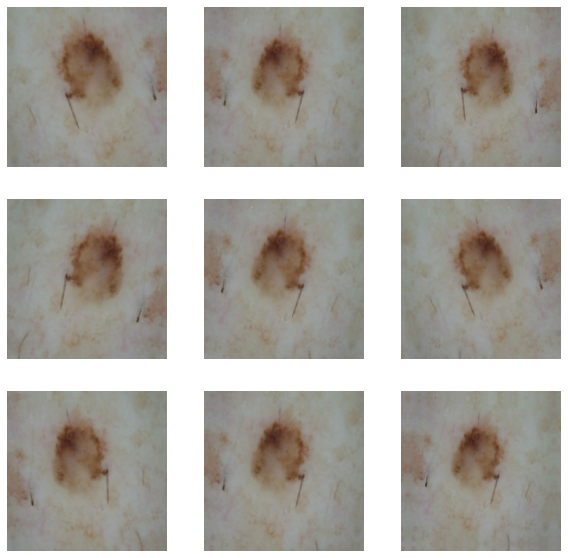

In [27]:
# plot a image with random augmentaion 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

## Dropout

Adding Dropout to the network is a form of *regularization* technique to reduce overfitting.

When a layer has Dropout it randomly drops the output units(neurons) from the layer in training process. Dropout takes a fractional number as its input value, as 0.1 ...0.9 means 10%...90% of the output units randomly drops from the applied layer.

Let's create a new neural network using `Dropout` along with augumentation layer added to the input images

# Model 2

In [28]:
### Your code goes here
model = Sequential()
model.add(data_augmentation)
model.add(norm_layer)

model.add(Conv2D(16, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))
model.add(layers.Flatten())
model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_3 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 128)      

,Layer Name,Filter,Kernel,Padding,Stride,Pool Size,Type,Rate
0,Sequential,,,,,,,
1,Rescaling,,,,,,,
2,Conv2D,16,"(3, 3)",same,"(1, 1)",,,
3,Activation,,,,,,relu,
4,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
5,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
6,Conv2D,128,"(3, 3)",valid,"(1, 1)",,,
7,Activation,,,,,,relu,
8,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
9,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,


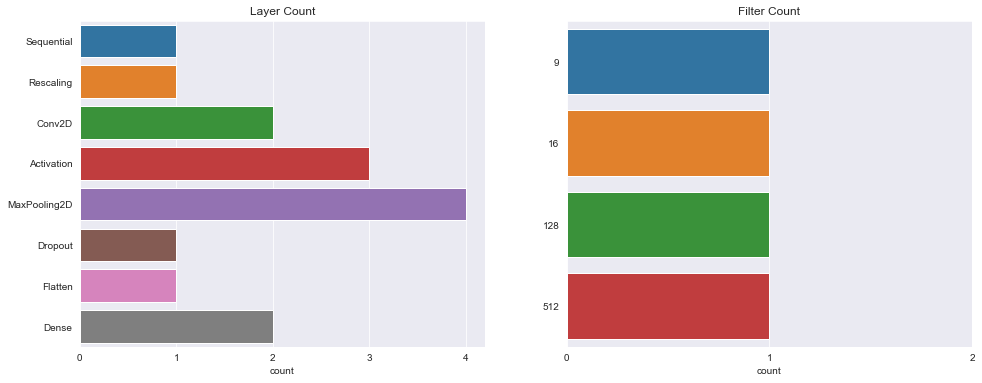

In [29]:
model_2 = get_model_summary(model)

# preview model
model_2

### Compiling the model

In [30]:
### set Optimiser and loss function as ADAM and SparceCategorialCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [31]:
# initialize the number of epochs to 20 and fit the buit bold with dataset
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 23ms/step - loss: 2.1957 - accuracy: 0.1852 - val_loss: 1.9245 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8051 - accuracy: 0.3374 - val_loss: 1.5836 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5444 - accuracy: 0.4482 - val_loss: 1.6175 - val_accuracy: 0.4094
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4507 - accuracy: 0.5046 - val_loss: 1.4155 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3820 - accuracy: 0.4988 - val_loss: 1.3665 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3199 - accuracy: 0.5406 - val_loss: 1.3844 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2797 - accuracy: 0.5412 - val_loss: 1.3222 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing the results

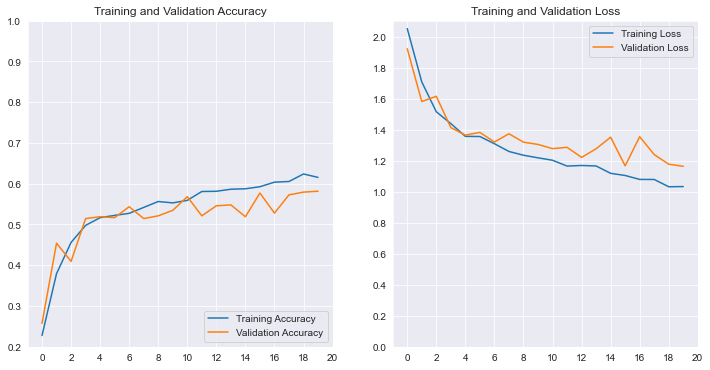

In [32]:
# set style
sns.set_style('darkgrid')

# get the accuracy of trian and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# get the loss of train and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# create subplot and sey figure size
plt.figure(figsize=(12, 6))

# set plot 1
plt.subplot(1, 2, 1)

# plot the accuracy of training and validation split
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# plot legends, title and ticks
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.yticks(np.linspace(0.2,1,9))
plt.xticks(np.linspace(0,20,11))
# set plot 2
plt.subplot(1, 2, 2)

# plot the loss function of training and validation split
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# plot legends, title and ticks
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.yticks(np.linspace(0.0,2,11))
plt.xticks(np.linspace(0,20,11))
plt.show()

## Observation :


*As* you can see from the plots, training accuracy and validation accuracy are too low, with a model able to achieve only around 60-70% accuracy on the train and validation set.

We can also notice that the loss of validation and training are high.

Let's look at what went wrong and try to increase the overall performance of the model.

### Underfitting

* In the plots above, the training accuracy increases only upto a range of 60-70%, whereas validation accuracy is between 50-60% in the training process. 

* The accuracy of training and validation is noticeable sign of underfitting.

This means that the model is more generilized than required and might not perform well on any dataset. The Underfitting can be handled in multiple ways in the training process. 

Lets use *Augumentor* to resample the low balanced classes. Lets first find the distribution of classes to see the imbalance in classes

In [33]:
class_map = pd.Series(class_names).to_dict()

In [34]:
batch = [labels.numpy() for images, labels in train_ds.take(len(train_ds))]

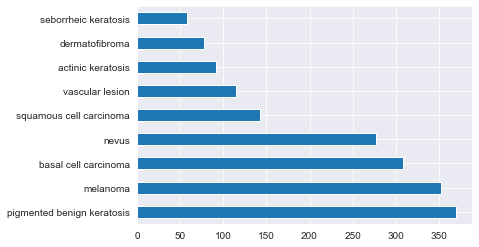

In [35]:
pd.Series(np.array(batch).flatten()).map(class_map).value_counts().plot(kind='barh');

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### ***Seborrheic keratosis** has least number of samples*
#### - Which classes dominate the data in terms proportionate number of samples?
####   ***Pigmented benign keratosis** has more No of samples*

Lets rectify the class imbalance by Augumentor to add more samples across all classes so that none of the classes have very few samples.

In [36]:
# install Augumentor package
!pip install Augmentor

You should consider upgrading via the 'D:\Softwares\Anaconda3\envs\tf\python.exe -m pip install --upgrade pip' command.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
# set the path of our train dataset images
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# import Augumentor
import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2953833DDC0>:   2%|██                                                                                          | 11/500 [00:00<00:04, 109.45 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29555E71280>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 388.35 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x295382F1DC0>:   8%|███████▎                                                                                     | 39/500 [00:00<00:05, 83.33 Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29555E320A0>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 377.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29555E9DF70>:   4%|████▏                                                                                                          | 19/500 [00:00<00:08, 58.82 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29538318550>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 349.04 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x29538325A00>:   0%|▏                                                                                                               | 1/500 [00:00<01:05,  7.63 Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2934DB24550>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 67.24 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x2955A283430>:   0%|▏                                                                                                               | 1/500 [00:00<01:21,  6.15 Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x2934DACE5B0>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2934DAC8280>:   4%|████▏                                                                                                          | 19/500 [00:00<00:08, 56.34 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2934DAD0DF0>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 368.19 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x29555EB7730>:   2%|█▊                                                                                                             | 8/500 [00:00<00:26, 18.61 Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2955A251940>: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 158.08 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2934DB2A400>:   5%|█████▌                                                                                                         | 25/500 [00:00<00:04, 96.62 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x29555E69A90>: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 358.42 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x295382FDE80>:   3%|███▎                                                                                                           | 15/500 [00:00<00:08, 59.11 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2955A260130>: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 325.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
# get the length of number of samples generated in all outout folders
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))

# preview total generated samples
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
# fetch all image path from output directory
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3de7d357-553c-4e22-bb0e-ebb393fbc76f.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c2fd639c-6d7b-4bd3-89af-105b87eee670.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_19e3cad9-a3fd-48f1-a912-97da260a16ff.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_79c255da-6829-4f16-9ee3-7b48ba30ada1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_84934f8e-c906-4b82-9581-49b2db2d3c55.jpg']

In [40]:
# extract the directory names of the parent folder for output directory
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [41]:
# create a dataframe with paths and classnames
dataframe_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
# get all image pathes expect for images from output folder
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

# create a dataframe with paths and classnames
dataframe_dict = dict(zip(path_list, lesion_list))

# transform the dictionary to dataframe
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [43]:
# transform the dictionary to dataframe
df2 = pd.DataFrame(list(dataframe_new.items()),columns = ['Path','Label'])

# merge both the DataFrames
new_df = original_df.append(df2)

In [44]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

All the classes has been resample with additonal 500 images samples. THis will help us overcome underfitting problems.

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
# initializet the batch size, image height and image width
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

# Model 3

In [48]:
# using the same model as before without augumentation layer
model = Sequential()
model.add(norm_layer)

model.add(Conv2D(16, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (3,3),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(layers.Flatten())
model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_6 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 43, 128)      

### Compiling the model

In [49]:
### set Optimiser and loss function as ADAM and SparceCategorialCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

,Layer Name,Filter,Kernel,Padding,Stride,Pool Size,Type,Rate
0,Rescaling,,,,,,,
1,Conv2D,16,"(3, 3)",same,"(1, 1)",,,
2,Activation,,,,,,relu,
3,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
4,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
5,Dropout,,,,,,,0.15
6,Conv2D,128,"(3, 3)",valid,"(1, 1)",,,
7,Activation,,,,,,relu,
8,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,
9,MaxPooling2D,,,valid,"(2, 2)","(2, 2)",,


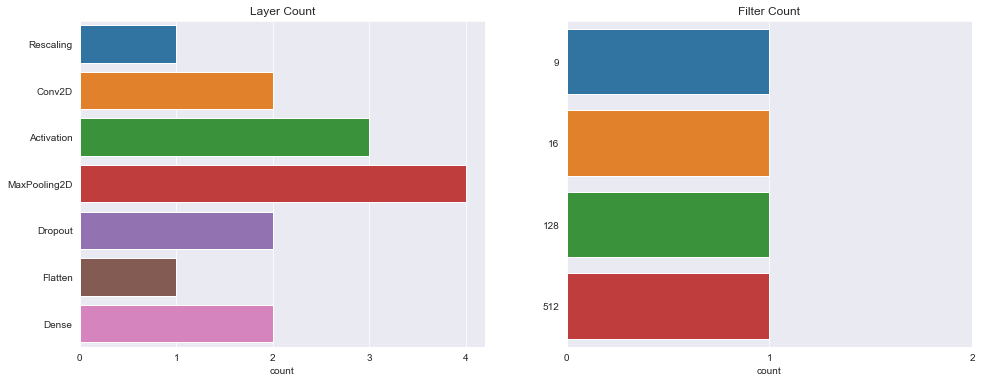

In [50]:
model_3 = get_model_summary(model)

# Preview model summary
model_3

#### **Todo:**  Train your model

In [51]:
# initialize the number of epochs to 30 and fit the built model with dataset
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 6s 35ms/step - loss: 2.2100 - accuracy: 0.1975 - val_loss: 1.6602 - val_accuracy: 0.3682
Epoch 2/30
169/169 [==============================] - 6s 33ms/step - loss: 1.4636 - accuracy: 0.4471 - val_loss: 1.3971 - val_accuracy: 0.4506
Epoch 3/30
169/169 [==============================] - 6s 34ms/step - loss: 1.2968 - accuracy: 0.5017 - val_loss: 1.2557 - val_accuracy: 0.5174
Epoch 4/30
169/169 [==============================] - 6s 35ms/step - loss: 1.1577 - accuracy: 0.5666 - val_loss: 1.1818 - val_accuracy: 0.5464
Epoch 5/30
169/169 [==============================] - 6s 34ms/step - loss: 1.0435 - accuracy: 0.6098 - val_loss: 1.1585 - val_accuracy: 0.5724
Epoch 6/30
169/169 [==============================] - 6s 33ms/step - loss: 0.9600 - accuracy: 0.6491 - val_loss: 1.0617 - val_accuracy: 0.6006
Epoch 7/30
169/169 [==============================] - 6s 33ms/step - loss: 0.8609 - accuracy: 0.6919 - val_loss: 1.0363 - val_accuracy: 0.6347

#### **Todo:**  Visualize the model results

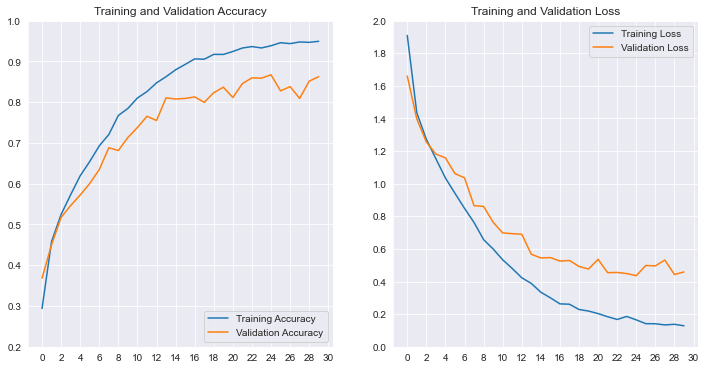

In [52]:
# set style
sns.set_style('darkgrid')

# get the accuracy of trian and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# get the loss of train and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# create subplot and sey figure size
plt.figure(figsize=(12, 6))

# set plot 1
plt.subplot(1, 2, 1)

# plot the accuracy of training and validation split
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# plot legends, title and ticks
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.yticks(np.linspace(0.2,1,9))
plt.xticks(np.linspace(0,30,16))
# set plot 2
plt.subplot(1, 2, 2)

# plot the loss function of training and validation split
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# plot legends, title and ticks
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.yticks(np.linspace(0.0,2,11))
plt.xticks(np.linspace(0,30,16))
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Model 1:
>  Train Accuracy has was in the range of 80-90% and Validation Accuracy din't go beyond 60%. This is the case of **overfitting**.

>  The validation loss was increasing as the epochs increased which made the model more complex at every iteration.

Model 2:
>  To over come the Model 1's overfitting  issue we introduced Dropout and augumentaion layers to reduce the model complexicity and introduce some noise.

>  Train Accuracy of our model was around 60-70% and Validation Accuracy in the range between 50%-60%, apparently this is becomes an **underfitting**.

>  The Training loss and validation loss are higher than normal model should have which is the case of underfit model. 

Model 3:
>   Model 1 & 2 has both underfitting and overfitting case respectivly, with a sequential step with now introduced resampling of images to fix the underfitting problem using augumentor instead of augumentation layer. 

>   This made the classes balanced across evenly and helped overcome the underfitting to a better model.

### Summary :

*   From our final model we can see that acurracy and loss are at its better number than previous models. 
*   The Dropouts helped in generilizng the model with optimal threshold.
*   The Augument helped in rebalancing the classes to overcome undefitting
